<a href="https://colab.research.google.com/github/john-hafner/PHY451-Muon/blob/main/Exponential_Fit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exponential Fit
The lab directions recommend using a fit of this form:

$$N(t) = N_0 e^{-\frac{t}{\tau}} + \Delta$$

$\tau$ is the mean lifetime<br>
$\Delta$ is the background count of muons that were incident but did not decay.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import curve_fit

In [ ]:
# TODO: Change this so instead of mounting my drive which causes a security
# prompt and can't be used by anyone else since it will mount "their" drive.
# Instead I'll simply share the data so anyone with the URL can load it, and
# then if they run the notebook it'll load my data.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Gets to base of your google drive, don't change this.
base = 'drive/My Drive'
# Specific folder the data is stored in, may be multiple levels in, separated
# by forward slashes (/)
folder = 'PHY451 - Muons/Our Data'
# file name
file = 'muon_3-14-23.data'

# Combine the above locations to the full file path.
file_path = base + '/' + folder + '/' + file
df = pd.read_csv(file_path, delim_whitespace=True, names=['decay_time', 'timestamp'], header=None)
#df = pd.read_csv(base + '/' + folder + '/' + file, delim_whitespace=True, names=['decay_time', 'timestamp'], header=None)
#df = pd.read_csv('drive/My Drive/PHY451 - Muons/Our Data/muon_3-14-23.data', delim_whitespace=True, names=['decay_time', 'timestamp'], header=None)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
print(f'Loaded {df.shape[0]} records')
print('Records of T < 20000:', df[df['decay_time'] < 20000].shape[0])
print('Records of 20000 < T < 40000:', df[(df['decay_time'] >= 20000) & (df['decay_time'] < 40000)].shape[0])
print('Records of T >= 40000:', df[df['decay_time'] >= 40000].shape[0])
df.head(5)

Loaded 8321311 records
Records of T < 20000: 17874
Records of 20000 < T < 40000: 7114368
Records of T >= 40000: 1189069


,decay_time,timestamp
0,40000,2023-02-28 16:47:15
1,40000,2023-02-28 16:47:16
2,40000,2023-02-28 16:47:17
3,40000,2023-02-28 16:47:18
4,40000,2023-02-28 16:47:19


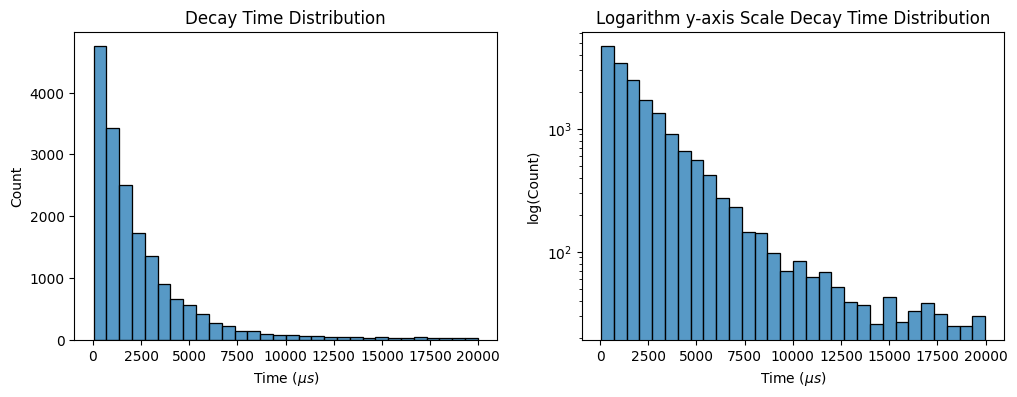

In [ ]:
decay_df = df[df['decay_time'] < 20000].reset_index()

num_bins = 30

fig, ax = plt.subplots(1, 2, figsize=(12,4))

sns.histplot(data=decay_df['decay_time'], ax=ax[0], bins=num_bins)
ax[0].set_title('Decay Time Distribution')
ax[0].set_xlabel('Time $(\mu s)$')
ax[0].set_ylabel('Count')

ax[1].set_title('Logarithm y-axis Scale Decay Time Distribution')
ax[1].set_yscale('log')
ax[1].set_xlabel('Time $(\mu s)$')
ax[1].set_ylabel('log(Count)')
sns.histplot(data=decay_df['decay_time'], ax=ax[1], bins=num_bins)
plt.show()

The data is loaded, it appears to follow the expected exponential shape on the left, and a logarithm scale on the right clearly shows it turns into a linear relationship for the most part, with the extreme right being indicitive of a background noise.

A key question will be the number of bins to use.

Also we'll want to remove the time range that is less than $0.1\ \mu s$ as the lab directions recommend.  The counts there are under represented and would impact the fit.  See below, the counts of the first 100 time values are plotted on a line.  The very first value is clearly out of the pattern.

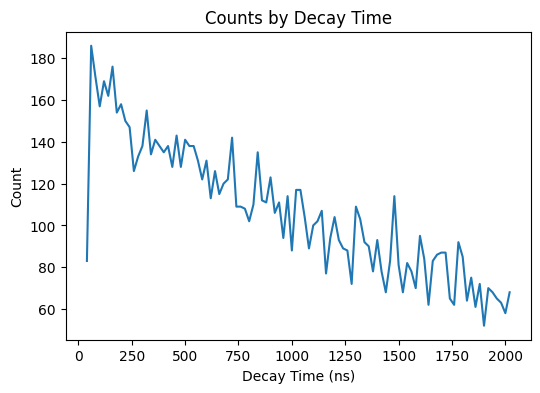

In [ ]:
plt.figure(figsize=(6,4))
plt.title('Counts by Decay Time')
plt.plot(decay_df.groupby('decay_time').count().iloc[:100,0])
plt.xlabel('Decay Time (ns)')
plt.ylabel('Count')
plt.show()

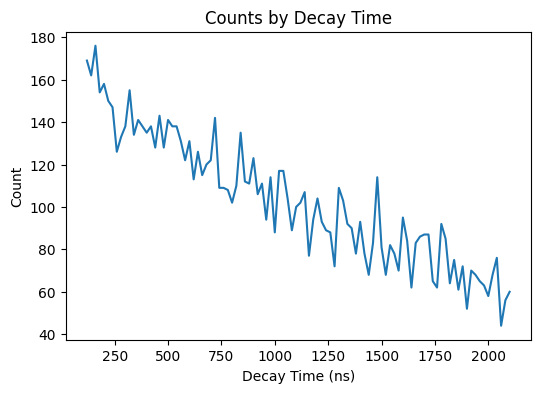

In [ ]:
decay_df = decay_df.loc[decay_df['decay_time'] > 100, :]
#decay_df.head()
#decay_df.groupby('decay_time').count().sort_values(by='decay_time')
plt.figure(figsize=(6,4))
plt.title('Counts by Decay Time')
plt.plot(decay_df.groupby('decay_time').count().iloc[:100,0])
plt.xlabel('Decay Time (ns)')
plt.ylabel('Count')
plt.show()

In [ ]:
decay_df['decay_time'].describe()

count    17277.000000
mean      2590.553916
std       2969.375932
min        120.000000
25%        740.000000
50%       1620.000000
75%       3260.000000
max      19980.000000
Name: decay_time, dtype: float64

The minimum value is 40 ns for the decay time.  The mean is $2.5\ \mu s$ which is promisingly close to the expected value.  But that's just a rough mean without any fitting or analysis.  And the $\sigma$ is even larger than it!  But still better than what I'd tried with the linear fit.

I'll use the curve_fit function from scipy's optimize package, where we just have to give it the general form of the function we're trying to fit, and a guess at the coefficients, and it will then attempt to find the best fit form of the function.

In [ ]:
bin_df = decay_df[decay_df['decay_time'] > 100].groupby('decay_time').count()
bin_df.describe()

,index,timestamp
count,832.000000,832.000000
mean,20.765625,20.765625
std,34.510594,34.510594
min,1.000000,1.000000
25%,2.000000,2.000000
50%,4.000000,4.000000
75%,22.000000,22.000000
max,176.000000,176.000000


In [ ]:
bin_df.rename(columns={'index': 'count'}, inplace=True)
bin_df.drop(columns=['timestamp'], inplace=True)
bin_df.head()

,count
decay_time,
120,169
140,162
160,176
180,154
200,158


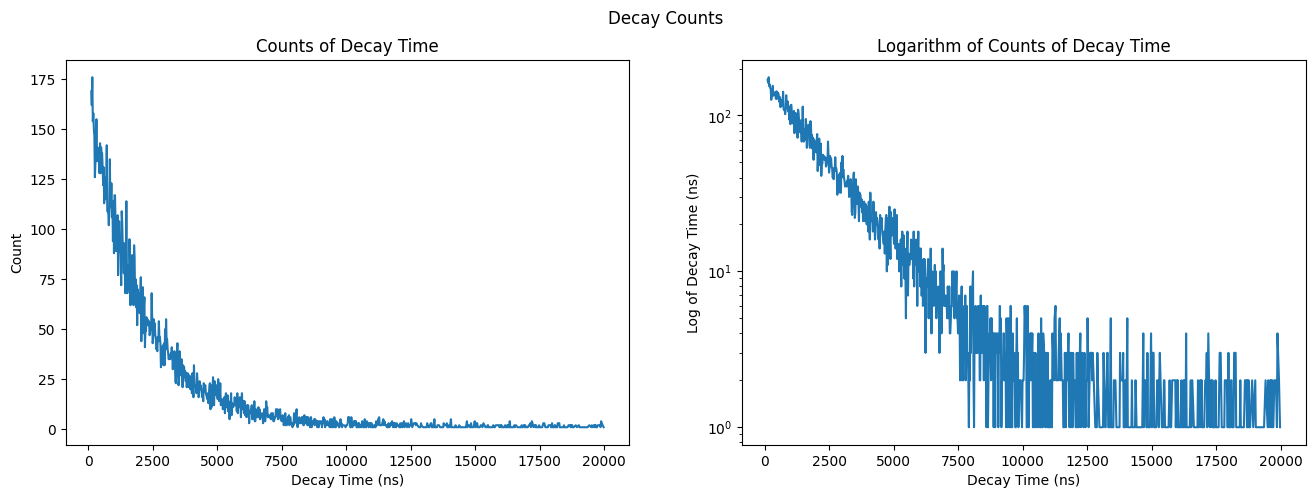

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))

ax[0].plot(bin_df)
ax[0].set_xlabel('Decay Time (ns)')
ax[0].set_ylabel('Count')
ax[0].set_title('Counts of Decay Time')

ax[1].plot(bin_df)
ax[1].set_xlabel('Decay Time (ns)')
ax[1].set_yscale('log')
ax[1].set_ylabel('Log of Decay Time (ns)')
ax[1].set_title('Logarithm of Counts of Decay Time')


fig.suptitle('Decay Counts')
# plt.title('Raw Decay Time Counts')
# plt.xlabel('Time (ns)')
# plt.ylabel('Count')
plt.show()

In [ ]:
y = bin_df.iloc[:, 0].astype(np.float64)
x = bin_df.index.to_series().astype(np.float64)
def muon_fit(t, N_0, T, B):
  return N_0 * np.exp(-t / T) + B

guess = [170, 2100, 1]
popt, pcov = curve_fit(muon_fit, x, y, p0=guess)
print(popt)
print(pcov)

[1.68206842e+02 2.02336083e+03 1.43866573e+00]
[[ 9.98129961e-01 -1.23593432e+01  8.52440294e-03]
 [-1.23593432e+01  3.73617388e+02 -2.30447936e+00]
 [ 8.52440294e-03 -2.30447936e+00  4.63484435e-02]]


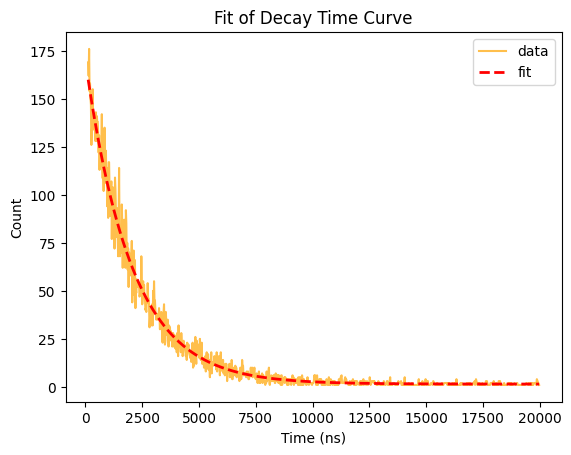

In [ ]:


plt.plot(bin_df, label='data', color='orange', alpha=0.7)
#x = np.linspace(0, 20000, 1000)
#y = 170 * np.exp(-x / 2100) + 1

#plt.scatter(x, y, s=50, c='red', zorder=3)
y_hat = muon_fit(x, popt[0], popt[1], popt[2])
plt.plot(x, y_hat, label='fit', color='red', linestyle='--', linewidth=2)

plt.title('Fit of Decay Time Curve')
plt.legend()
plt.xlabel('Time (ns)')
plt.ylabel('Count')
plt.show()

The curve fit from scipy gets a value of $2.02\ \mu s$.  A bit low compared to the accepted answer, but reasonable.

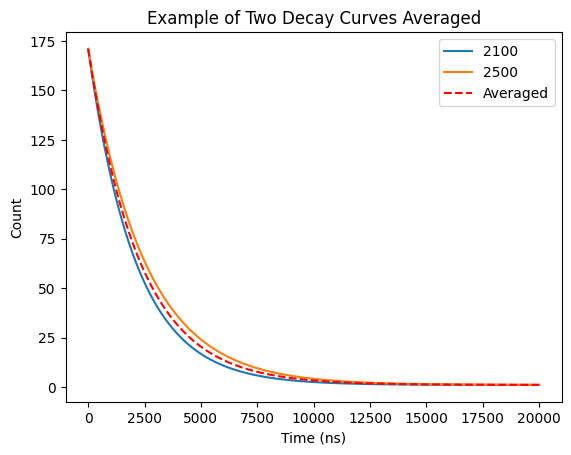

In [ ]:


#plt.plot(bin_df, label='data', color='orange', alpha=0.7)
x = np.linspace(0, 20000, 1000)
y = 170 * np.exp(-x / 2100) + 1
plt.plot(x, y, label='2100')

y2 = 170 * np.exp(-x / 2500) + 1
plt.plot(x, y2, label='2500')

y_avg = (y + y2) / 2
plt.plot(x, y_avg, color='red', linestyle='--', label='Averaged')
#plt.scatter(x, y, s=50, c='red', zorder=3)
#y_hat = muon_fit(x, popt[0], popt[1], popt[2])
#plt.plot(x, y_hat, label='fit', color='red', linestyle='--', linewidth=2)

plt.title('Example of Two Decay Curves Averaged')
plt.legend()
plt.xlabel('Time (ns)')
plt.ylabel('Count')
plt.show()